# Text mining


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Useful Python packages for text analysis
Below is a list of useful packages for web scraping, text pre-processing, analysis and word embeddings, with instructions how to install them.


In this exercise we will mostly be using  classes from *sklearn.feature_extraction.text* which only implement relatively simple text-processing methods and *nltk*, *spacy*, *wordcloud* and *pyLDAvis*. Please install *nltk*, *spacy*, *wordcloud* and *pyLDAvis* in your conda environment.

 * **Natural Language Toolkit (NLTK)**: Useful NLP tools.
 
    `conda install nltk`

 * **Scikit Learn**: Includes some NLP tasks.
    
 *  **Spacy**: Useful NLP tools.
 
 `conda install -c conda-forge spacy`
 
    You also need to download the English language support for *spacy* by executing in your environment
 
    `python -m spacy download en_core_web_sm`

 * **Gensim**: Word2vec library.
 
 `conda install -c anaconda gensim`
 
 * **pyLDAvis **  Interactive topic model visualization
 
 `conda install -c conda-forge pyldavis`
 
 * **python-Levenshtein**: Calculate similarity distances between strings.
 
 `conda install -c conda-forge python-levenshtein`
 
 * **BeautifulSoup**: HTML parser, web scraping.
 
    `conda install -c anaconda beautifulsoup4`
 
 * **WordCloud**: for visualizing wordclouds.
  
  
   `conda install -c conda-forge wordcloud`

If you want to learn more, you can consult the following book: Natural Language Processing with Python by Steven Bird, Ewan Klein, and Edward Loper, which provides an overview of NLP together with an introduction to the *nltk* Python package for NLP.
http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf

The following exercise is taken from Chapter 7 of Introduction to Machine Learning with Python by Andreas C. Müller, Sarah Guido.

### Types of Data Represented as Strings
Before we dive into the processing steps that go into representing text data for machine learning, we want to briefly discuss different kinds of text data that you might encounter. Text is usually just a string in your dataset, but not all string features should be treated as text. There are four kinds of string data you might see:
- Categorical data
- Free strings that can be semantically mapped to categories
- Structured string data
- Text data

Categorical data is data that comes from a fixed list. Say you collect data via a survey where you ask people their favorite color, with a drop-down menu that allows them to select from "red", "green", "blue", "yellow", "black", "white", "purple" and "pink". This will result in a dataset with exactly eight different possible values, which clearly encode a categorical variable. You can check whether this is the case for your data by eyeballing it (if you see very many different strings it is unlikely that this is a categorical variable) and confirm it by computing the unique values over the dataset, and possibly a histogram over how often each appears. You also might want to check whether each variable actually corresponds to a category that makes sense for your application. Maybe halfway through the existence of your survey, someone found that “black” was misspelled as “blak” and subsequently fixed the survey. As a result, your dataset contains both "blak" and “black,” which correspond to the same semantic meaning and should be consolidated.

Now imagine instead of providing a drop-down menu, you provide a text field for the users to provide their own favorite colors. Many people might respond with a color name like “black” or “blue.” Others might make typographical errors, use different spellings like "gray" and “grey,” or use more evocative and specific names like “midnight blue.” You will also have some very strange entries. Some good examples come from the xkcd Color Survey, where people had to name colors and came up with names like “velociraptor cloaka” and “mydentist’s office orange” which are hard to map to colors automatically (or at all). The responses you can obtain from a text field belong to the second category in the list, free strings that can be semantically mapped to categories. It will probably be best to encode this data as a categorical variable, where you can select the categories either by using the most common entries, or by defining categories that will capture responses in a way that makes sense for your application. You might then have some categories for standard colors, maybe a category “multicolored” for people that gave answers like “green and red stripes,” and an “other” category for things that cannot be encoded otherwise. This kind of preprocessing of strings can take a lot of manual effort and is not easily automated. If you are in a position where you can influence data collection, we highly recommend avoiding manually entered values for concepts that are better captured using categorical variables.
 
Often, manually entered values do not correspond to fixed categories, but still have some underlying structure, like addresses, names of places or people, dates, telephone numbers, or other identifiers. These kinds of strings are often very hard to parse, and their treatment is highly dependent on context and domain. 

The final category of string data is freeform text data that consists of phrases or sentences. Examples include tweets, chat logs, and hotel reviews, as well as the collected works of Shakespeare, the content of Wikipedia, or the Project Gutenberg collection of 50,000 ebooks. All of these collections contain information mostly as sentences composed of words.
For simplicity’s sake, let’s assume all our documents are in one language, English. In the context of text analysis, the dataset is often called the *corpus*, and each data point, represented as a single text, is called a *document*. These terms come from the information retrieval(IR) and natural language processing (NLP) community, which both deal mostly intext data.

## Example Application: Sentiment Analysis of MovieReviews
As a running example, we will use a dataset of movie reviews from the IMDb (Internet Movie Database) website collected by Stanford researcher Andrew Maas.
This dataset contains the text of the reviews, together with a label that indicates whether a review is “positive” or “negative.” TheIMDb website itself contains ratings from 1 to 10. To simplify the modeling, this annotation is summarized as a two-class classification dataset where reviews with a score of 7 or higher are labeled as positive, and a score 4 or lower is labeled as negative (neutral reviews are not included in the dataset). We will leave the question of whether this is a good representation of the data open, and simply use the data as provided by Andrew Maas. If you’re on OS X or Linux, you can download and unpack the data using:

In [3]:
! wget -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -P data
! tar xzf data/aclImdb_v1.tar.gz --skip-old-files -C data

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Option --skip-old-files is not supported
Usage:
  List:    tar -tf <archive-filename>
  Extract: tar -xf <archive-filename>
  Create:  tar -cf <archive-filename> [filenames...]
  Help:    tar --help


If you are not not on OS X or Linux, go the webpage: </br>
http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
download the file, unzip it and place the unzipped folder *aclImdb* into a folder named *data* (which you can create in the directory where your notebook is).

After unpacking the data, the data set is provided as text files in two separate folders, one for the training data, and one for the test data. Each of these in turn has two subfolders, one called “positive” and one called “negative”. The *pos* folder contains all the positive reviews, each as a separate text file, and similarly for the *neg* folder. The *unsup* folder contains unlabeled data, which we won’t use, and so hence you should delete it manually.

There is a helper function in *scikit-learn* to load files stored in such a folder structure, where each subfolder corresponds to a label, called *load_files*. We apply the *load_files* function first to the training data. (Note that executing this cells might take a while.)

In [4]:
from sklearn.datasets import load_files

reviews_train = load_files("data/aclImdb/train/")
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

type of text_train: <class 'list'>
length of text_train: 25000
text_train[6]:
b"This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."


The type of the entries of *text_train* will depend on your Python version. In Python 3, they will be of type bytes which represents a binary encoding of the string data. In Python 2, *text_train* contains strings. 


You can see that *text_train* is a list of length 25,000, where each entry is a string containing a review. We printed the review with index 6. You can also see that the review contains some HTML line breaks (\<br />). While these are unlikely to have a large impact on our machine learning models, it is better to clean the data and remove this formatting before we proceed.

We will use *replace* which is an inbuilt function in Python programming language that returns a copy of the string where all occurrences of a substring is replaced with another substring. Its syntax is *string.replace(old, new, count)*.

In [5]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

The character *b* before the quotes, denotes the byte type:

Bytes literals are always prefixed with 'b' or 'B'; they produce an instance of the bytes type instead of the str type. They may only contain ASCII characters; bytes with a numeric value of 128 or greater must be expressed with escapes.

Let's now check the same review and see how \<br /> have been replaced with an empty string.

In [6]:
print("text_train[6]:\n{}".format(text_train[6]))

text_train[6]:
b"This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.  Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life.   I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."


The dataset was collected such that the positive class and the negative class balanced, so that there are as many positive as negative strings:

In [7]:
print("Samples per class (training): {}".format(np.bincount(y_train)))

Samples per class (training): [12500 12500]


We load the test dataset in the same manner: (Note that executing this cell might take a while).

In [8]:
reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: {}".format(len(text_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Number of documents in test data: 25000
Samples per class (test): [12500 12500]


The task we want to solve is as follows: given a review, we want to assign the label “positive” or “negative” based on the text content of the review. This is a standard binary classification task. However, the text data is not in a format that a machine learning model can handle. We need to convert the string representation of the text into a numeric representation that we can apply our machine learning algorithms to.

### Representing Text Data as a Bag of Words
One of the most simple but effective and commonly used ways to represent text for machine learning is using the bag-of-words representation. When using this representation, we discard most of the structure of the input text, like chapters, paragraphs, sentences, and formatting, and only count how often each word appears in each text in the corpus. Computing the bag-of-words representation for a corpus of documents consists of the following three steps:
1.   Tokenization<br>
Split each document into the words that appear in it (called tokens ), for example by splitting them on whitespace and punctuation.

2.   Vocabulary building<br>
Collect a vocabulary of all words that appear in any of the documents, and number them (say, in alphabetical order).

3.  Encoding<br>
For each document, count how often each of the words in the vocabulary appear in this document. Now, let’s look at how we can apply the bag-of-words processing using *scikit-learn*.

The next figure illustrates the process on the string "This is how you get ants."<br>
The output is one vector of word counts for each document. For each word in the vocabulary, we have a count of how often it appears in each document. That means our numeric representation has one feature for each unique word in the whole dataset. Note how the order of the words in the original string is completely irrelevant to the bag-of-words feature representation.
<div>
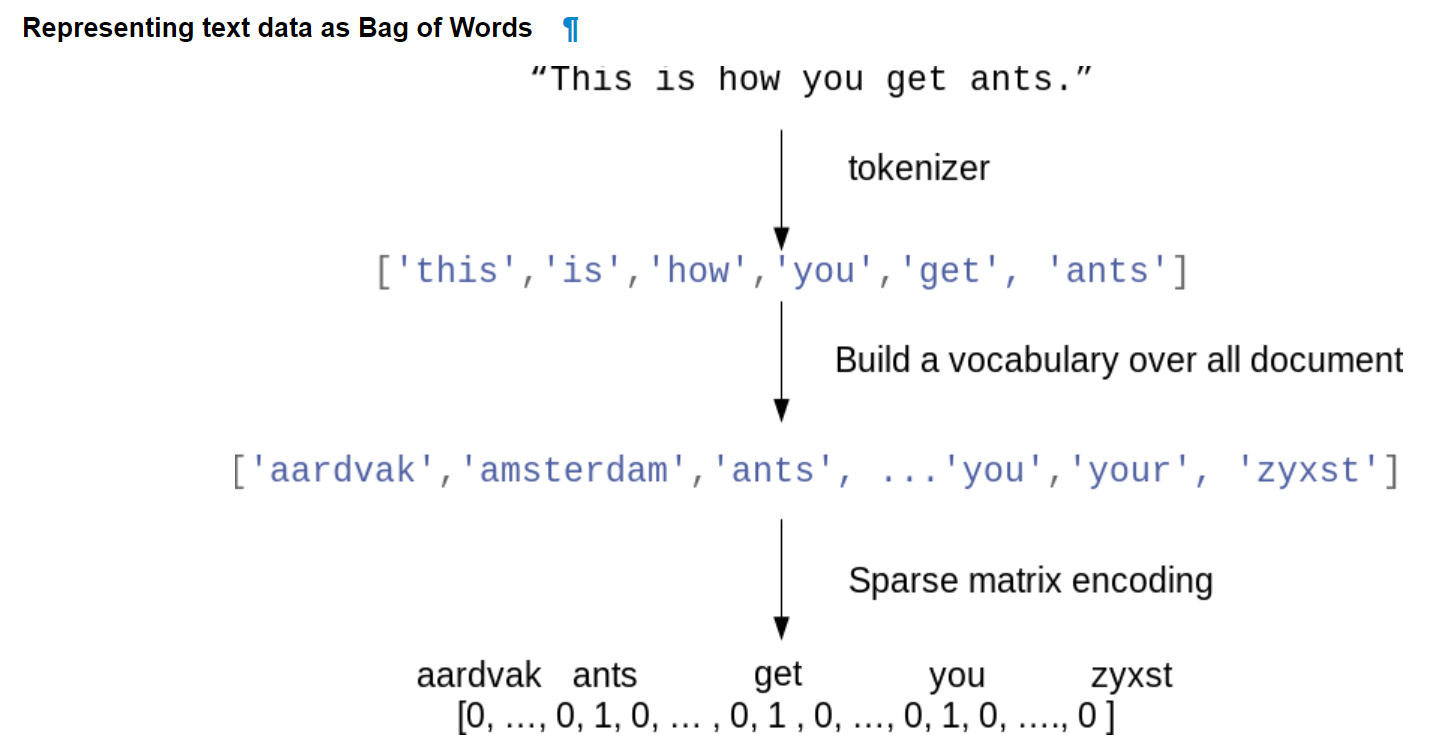
</div>


The bag-of-words representation is implemented in *CountVectorizer*, whichis a transformer. Let’s first apply it to a toy dataset, consisting of two samples, to see it working:

In [9]:
bards_words=[
    "The fool doth think he is wise,",
     "but the wise man knows himself to be a fool" ]

We import and instantiate the *CountVectorizer* and fit it to our toy data as follows:

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

Fitting the *CountVectorizer* consists of the tokenization of the training data and building of the vocabulary, which we can access with the
*vocabulary_* attribute:

In [11]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


Another way to access the vocabulary is using the *get_feature_name*  method of the vectorizer, which returns a convenient list where each entry corresponds to one feature:

In [12]:
vect.get_feature_names()

['be',
 'but',
 'doth',
 'fool',
 'he',
 'himself',
 'is',
 'knows',
 'man',
 'the',
 'think',
 'to',
 'wise']

The vocabulary consists of 13 words. To create the bag-of-words representation for the training data, we call the *transform* method.
We will also use *repr* function to return a printable representation of the given object to see its size.

In [13]:
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


The bag-of-words representation is stored in a *SciPy* sparse matrix that only stores the entries that are nonzero. The matrix is of shape 2×13, with one row for each of the two data points and one feature for each of the words in the vocabulary. A sparse matrix is used as most documents only contain a small subset of the words in the vocabulary, meaning most entries in the feature array are 0. Think about how many different words might appear in a movie review compared to all the words in the English language (which is what the vocabulary models). Storing all those zeros would be prohibitive, and a waste of memory. To look at the actual content of the sparse matrix, we can convert it to a "dense" *NumPy* array (that also stores all the 0 entries) using the *toarray* method:

In [14]:
pd.DataFrame(bag_of_words.toarray(), columns=vect.get_feature_names())

,be,but,doth,fool,he,himself,is,knows,man,the,think,to,wise
0,0,0,1,1,1,0,1,0,0,1,1,0,1
1,1,1,0,1,0,1,0,1,1,1,0,1,1


We can see that the word counts for each word are either 0 or 1; neither of the two strings in bards_words contains a word twice. Let’s take a look at how to read these feature vectors. The first string ("The fool doth think he is wise,") is represented as the first row in, and it contains the first word in the vocabulary, "be" , zero times. It also contains the second word in the vocabulary, "but", zero times. It contains the third word, "doth", once, and so on. Looking at both rows, we can see that the fourth word, "fool", the tenth word, "the",and the thirteenth word, "wise", appear in both strings.

Now that we’ve gone through the bag-of-words process in detail, let’s apply it to our task of sentiment analysis for movie reviews. Earlier, we loaded our training and test data from the IMDb reviews into lists of strings (*text_train* and *text_test*), which we will now process:

In [15]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


The shape of *X_train*, the bag-of-words representation of the training data, is 25,000×74,849, indicating that the vocabulary contains 74,849 entries. Again, the data is stored as a *SciPy* sparse matrix. Let’s look at the vocabulary in a bit more detail:

In [16]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 74849
First 20 features:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
Features 20010 to 20030:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Every 2000th feature:
['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


As you can see, possibly a bit surprisingly, the first 10 entries in the vocabulary are is likely to refer to the James Bond character.
Weeding out the meaningful from the nonmeaningful “words” is sometimes tricky. Looking further along in the vocabulary, we find a collection of English words starting with “dra”. You might notice that for "draught", "drawback", and "drawer" both the singular and plural forms are contained in the vocabulary as distinct words. These words have very closely related semantic meanings, and counting them as different words, corresponding to different features, might not be ideal.

Before we try to improve our feature extraction, let’s obtain a quantitative measure of performance by actually building a classifier. We have the training labels stored in *y_train* and the bag-of-words representation of the training data in *X_train*, so we can train a classifier on this data. For high-dimensional, sparse data like this, linear models like *LogisticRegression* often work best.

Let’s start by evaluating *LogisticRegression* using cross-validation:

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(solver='liblinear'), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.88


We obtain a mean cross-validation score of 88%, which indicates reasonable per‐formance for a balanced binary classification task. We know that *LogisticRegression* has a regularization parameter, *C*, which we can tune via cross-validation (again, this might take a while):

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.89
Best parameters:  {'C': 0.1}


We obtain a cross-validation score of 89% using *C=0.1*. We can now assess the generalization performance of this parameter setting on the test set:

In [19]:
X_test = vect.transform(text_test)
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.88


Now, let’s see if we can improve the extraction of words. The *CountVectorizer* extracts tokens using a regular expression. By default, the regular expression that is used is "\b\w\w+\b". If you are not familiar with regular expressions, this means it finds all sequences of characters that consist of at least two letters or numbers (\w) and that are separated by word boundaries (\b).It does not find single-letter words, and it splits up contractions like “doesn’t” or “bit.ly”, but it matches “h8ter” as a single word. The *CountVectorizer*
then converts all words to lowercase characters, so that “soon”, “Soon”, and “sOon” all correspond to the same token (and therefore feature). This simple mechanism works quite well in practice, but as we saw earlier, we get many uninformative features (like the numbers). One way to cut back on these is to only use tokens that appear in at least two documents (or at least five documents, and so on). A token that appears only in a single document is unlikely to appear in the test set and is therefore not helpful. We can set the minimum number of documents a token needs to appear in with the *min_df* parameter:

In [20]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


By requiring at least five appearances of each token, we can bring down the number of features to 27,272, as seen in the preceding output: only about a third of the original features. Let’s look at some tokens again:

In [21]:
feature_names = vect.get_feature_names()

print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
Features 20010 to 20030:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 700th feature:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciati

There are clearly many fewer numbers, and some of the more obscure words or misspellings seem to have vanished. Let’s see how well our model performs by doing a grid search again:

In [22]:
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.89


The best validation accuracy of the grid search is still 89%, unchanged from before. We didn’t improve our model, but having fewer features to deal with speeds up processing and throwing away useless features might make the model more interpretable.

### Stopwords
Another way that we can get rid of uninformative words is by discarding words that are too frequent to be informative. There are two main approaches: using a language-specific list of stopwords, or discarding words that appear too frequently.
*scikit-learn* has a built-in list of English stopwords in the *feature_extraction.text* module:

In [23]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['fifty', 'some', 'behind', 'am', 'bottom', 'being', 'such', 'hasnt', 'often', 'own', 'no', 'interest', 'everywhere', 'still', 'much', 'eleven', 'her', 'moreover', 'so', 'third', 'has', 'this', 'me', 'their', 'yet', 'above', 'seemed', 'against', 'else', 'whose', 'us', 'with']


Clearly, removing the stopwords in the list can only decrease the number of features by the length of the list—here, 318—but it might lead to an improvement in performance. Let’s give it a try:

In [24]:
# Specifying stop_words="english" uses the built-in list.
# We could also augment it and pass our own.
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


There are now 305 (27,272–26,967) fewer features in the dataset, which means that most, but not all, of the stopwords appeared. Let’s run the grid search again:

In [25]:
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.88


The grid search performance decreased slightly using the stopwords, not enough to worry about, but given that excluding 305 features out of over 27,000 is unlikely to change performance or interpretability a lot, it doesn’t seem worth using this list. Fixed lists are mostly helpful for small datasets, which might not contain enough information for the model to determine which words are stopwords from the data itself. As an exercise, you can try out the other approach, discarding frequently appearing words, by setting the *max_df* option of *CountVectorizer* and see how it influences the number of features and the performance.

### Rescaling the Data with tf–idf
Instead of dropping features that are deemed unimportant, another approach is to rescale features by how informative we expect them to be. One of the most common ways to do this is using the term frequency–inverse document frequency (tf–idf) method. The intuition of this method is to give high weight to any term that appears often in a particular document, but not in many documents in the corpus. If a word appears often in a particular document, but not in very many documents, it is likely to be very descriptive of the content of that document. *scikit-learn* implements the tf–idf method in two classes:
- *TfidfTransformer*, which takes in the sparse matrix output produced by *CountVectorizer* and transforms it
- *TfidfVectorizer*, which takes in the text data and does both the bag-of-words feature extraction and the tf–idf transformation. 

There are several variants of the tf–idf rescaling scheme. The tf–idf score for word *w* in document *d* as implemented in both the
*TfidfTransformer* and *TfidfVectorizer* classes is given by:

<div>
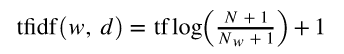
</div>

where $N$ is the number of documents in the training set, $N_w$ is the number of documents in the training set that the word
$w$ appears in, and tf (the term frequency) is the number of times that the word $w$ appears in the query document $d$
(the document you want to transform or encode). 
Both classes also apply L2 normalization after computing the tf–idf representation; in other words, they rescale the representation of each document to have Euclidean length 1.

Note, with the parameter *smooth_idf=False* the expression for IDF becomes:
<div>
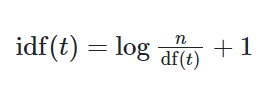
</div>

Because tf–idf actually makes use of the statistical properties of the training data, we will use a pipeline to ensure the results of our gridsearch are valid. This leads to the following code:

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(solver='liblinear'))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.89


In this case, tf–idf had no impact. We can also inspect which words tf–idf found most important. Keep in mind that the tf–idf scaling is meant to find words that distinguish documents, but it is a purely unsupervised technique. So, “important” here does not necessarily relate to the “positive review” and “negative review” labels we are interested in. First, we extract the *TfidfVectorizer* from the pipeline

In [27]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset:
X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over dataset:
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Features with highest tfidf: 
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


Features with low tf–idf are those that either are very commonly used across documents or are only used sparingly, and only in very long documents. Interestingly, many of the high-tf–idf features actually identify certain shows or movies. These terms only appear in reviews for this particular show or franchise, but tend to appear very often in these particular reviews. This is very clear, for example, for "homer", "timon", and "titanic".  These words are unlikely to help us in our sentiment classification task (unless maybe some franchises are universally reviewed positively or negatively) but certainly contain a lot of specific information about the reviews.

We can get document frequency values found on the training set by using *idf_* attribute:

In [28]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


As expected, these are mostly English stopwords like "the" and "no". But some are clearly domain-specific to the movie reviews, like  movie", "film", "time", "story", and so on. Interestingly, "good", "great", and "bad" are also among the most frequent and therefore “least relevant” words according to the tf–idf measure, even though we might expect these to be very important for our sentiment analysis task.

### Investigating Model Coefficients
Finally, let’s look in a bit more detail into what our logistic regression model actually learned from the data. Because there are so many features, 27,272, after removing the infrequent ones, we clearly cannot look at all of the coefficients at the same time. However, we can look at the largest coefficients, and see which words these correspond to. We will use the last model that we trained, based onthe tf–idf features.

Let's look at the 25 largest and 25 smallest coefficients of the logistic regression model.

In [29]:
sorted_coeff = np.argsort(grid.best_estimator_.named_steps["logisticregression"].coef_)
print(feature_names[sorted_coeff[0,:25]])

['worst' 'waste' 'awful' 'bad' 'boring' 'poor' 'poorly' 'worse' 'terrible'
 'disappointment' 'horrible' 'nothing' 'unfortunately' 'dull'
 'disappointing' 'avoid' 'save' 'mess' 'fails' 'stupid' 'ridiculous'
 'annoying' 'lacks' 'lame' 'badly']


In [30]:
print(feature_names[sorted_coeff[0,-25:]])

['fantastic' 'wonderfully' 'rare' 'bit' 'liked' 'definitely' 'job'
 'refreshing' 'funniest' 'enjoyable' 'brilliant' 'well' 'highly' 'enjoyed'
 'superb' 'fun' 'today' 'favorite' 'amazing' 'loved' 'wonderful' 'best'
 'perfect' 'excellent' 'great']


The negative coefficients belong to words that according to the model are indicative of negative reviews, while the positive coefficients belong to words that according to the model indicate positive reviews. Most of the terms are quite intuitive, like "worst", "waste", "disappointment", and "terrible" indicating bad movie reviews, while "excellent", "wonderful", "enjoyable", and "refreshing" indicate positive movie reviews. Some words are slightly less clear, like "bit" or "job" but these might be part of phrases like “good job”.

### Bag-of-Words with More Than One Word (n-Grams)
One of the main disadvantages of using a bag-of-words representation is that word order is completely discarded. Therefore, the two strings “it’s bad, not goodat all” and “it’s good, not bad at all” have exactly the same representation, eventhough the meanings are inverted. Putting “not” in front of a word is only one example (if an extreme one) of how context matters. Fortunately, there is a way of capturing context when using a bag-of-words representation, by not only considering the counts of single tokens, but also the counts of pairs or triplets of tokens that appear next to each other. Pairs of tokens are known as *bigrams*, triplets of tokens are known as *trigrams*, and more generally sequences of tokens are known as *n-grams*. We can change the range of tokens that are considered as features by changing the *ngram_range* parameter of *CountVectorizer* or *TfidfVectorizer*. The *ngram_range* parameter is a tuple, consisting of the minimum length and the maximum length of the sequences of tokens that are considered. Here is an example on the toy data we used earlier:

In [31]:
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


The default is to create one feature per sequence of tokens that is at least one token long and at most one token long, or in other words exactly one token long(single tokens are also called *unigrams*):

In [32]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


To look only at bigrams, that is, only at sequences of two tokens following each other, we can set *ngram_range* to (2, 2):

In [33]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


Using longer sequences of tokens usually results in many more features, and in more specific features. There is no common bigram between the two phrases in *bard_words*:

In [34]:
pd.DataFrame(cv.transform(bards_words).toarray(), columns=cv.get_feature_names())



,be fool,but the,doth think,fool doth,he is,himself to,is wise,knows himself,man knows,the fool,the wise,think he,to be,wise man
0,0,0,1,1,1,0,1,0,0,1,0,1,0,0
1,1,1,0,0,0,1,0,1,1,0,1,0,1,1


For most applications, the minimum number of tokens should be one, as single words often capture a lot of meaning. Adding bigrams helps in most cases. Adding longer sequences—up to 5-grams—might help too, but this will lead to an explosion of the number of features and might lead to overfitting, as there will be many very specific features. In principle, the number of bigrams could be the number of unigrams
squared and the number of trigrams could be the number of unigrams to the power of three, leading to very large feature spaces. In practice, the number of higher n-grams that actually appear in the data is much smaller, because of the structure of the (English) language, though it is still large.

Here is what using unigrams, bigrams, and trigrams on *bards_words* looks like:

In [35]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


Let’s try out the *TfidfVectorizer* on the IMDb movie review data and find the best setting of n-gram range using a grid search:

In [36]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(solver='liblinear'))
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = { 'logisticregression__C': [100],
                'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.91
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


As you can see from the results, we improved performance by a bit more than a percent by adding bigram and trigram features. Let's check the crossvalidation accuracy as a function of the *ngram_range*:

In [37]:
list_results=list(zip( param_grid['tfidfvectorizer__ngram_range'], grid.cv_results_['mean_test_score']))
pd.DataFrame(list_results, columns = ['ngram_range', 'accuracy'])

,ngram_range,accuracy
0,"(1, 1)",0.88264
1,"(1, 2)",0.90568
2,"(1, 3)",0.90644


We can see that using bigrams increases performance quite a bit, while adding trigrams only provides a very small benefit in terms of accuracy. To understand better how the model improved, we can check the important coefficient for the best model, which includes unigrams, bigrams, and trigrams.

In [38]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
sorted_coeff = np.argsort(coef)
print(feature_names[sorted_coeff[0,:25]])

['worst' 'bad' 'awful' 'boring' 'poor' 'the worst' 'waste' 'poorly'
 'worse' 'terrible' 'disappointment' 'horrible' 'disappointing' 'dull'
 'unfortunately' 'annoying' 'nothing' 'no' 'mess' 'stupid' 'lame'
 'ridiculous' 'lacks' 'script' 'oh']


There are particularly interesting features containing the word “worth” that were not present in the unigram model: "not worth" is  indicative of a negative review, while "definitely worth" and "well worth" are indicative of a positive review. This is a prime example of context influencing the meaning of the word “worth.”

Next, we’ll visualize only trigrams, to provide further insight into why these features are helpful. Many of the useful bigrams and trigrams consist of common words that would not be informative on their own, as in the phrases "none of the", "the only good","on and on","this is one", "of the most", and so on. However, the impact of these features is quite limited compared to the importance of the unigram features.

In [39]:
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# visualize only 3-gram features
coef = coef.ravel()[mask]
sorted_coeff = np.argsort(coef)
feature_names=feature_names[mask]
print(feature_names[sorted_coeff[:25]])
print(feature_names[sorted_coeff[-25:]])

['of the worst' 'waste of time' 'if they are' 'not one of'
 'supposed to be' 'first of all' 'none of the' 'to sit through'
 'the only good' 'some kind of' 'with this film' 'to work with'
 'better than this' 'the worst movie' 'would not recommend'
 'this film just' 'of the movie' 'nothing more than' 'not very good'
 'love the series' 'wanted to like' 'best things in' 'is not good'
 'of my life' 'want to see']
['the best movie' 'but it is' 'this is great' 'what it is' 'would love to'
 'check it out' 'of the most' 'the movie however' 'is the definitive'
 'this was the' 'don want to' 'as much as' 'lot of fun' 'may not be'
 'if you don' 'highly recommend this' '10 out of' 'must see for'
 'one of my' 'at the end' 'was pretty good' 'it was very' 'is the best'
 'much better than' 'of the best']


### Advanced Tokenization, Stemming, and Lemmatization
The feature extraction in the *CountVectorizer* and *TfidfVectorizer* is relatively simple, and much more elaborate methods are possible. One particular step that is often improved in more sophisticated text-processing applications is the first step in the bag-of-words model: tokenization. This step defines what constitutes a word for the purpose of feature extraction.
We saw earlier that the vocabulary often contains singular and plural versions of some words, as in "drawback" and "drawbacks", "drawer"
and "drawers" , and drawing" and "drawings". For the purposes of a bag-of-words model, the semantics of "drawback" and "drawbacks" are so close that distinguishing them will only increase overfitting, and not allow the model to fully exploit the training data. Similarly, we found the vocabulary includes words like "replace", "replaced", "replacement", "replaces", and "replacing", which are different verb forms and a noun relating to the verb “to replace.” Similarly to having singular and plural forms of a noun, treating different verb forms and related words as distinct tokens is disadvantageous for building a model that generalizes well.

This problem can be overcome by *stemming* and *lemmatization* which both generate the root form of the inflected words. The difference is that stem might not be an actual word whereas, lemma is an actual language word.
Both processing methods, lemmatization and stemming, are forms of normalization that try to extract some normal form of a word. Another interesting case of normalization is spelling correction, which can be helpful in practice but is outside of the scope of this exercise.
To get a better understanding of normalization, let’s compare a method for stemming. the Porter stemmer, a widely used collection of heuristics (here importedfrom the *nltk* package)—to lemmatization as implemented in the *spacy* package:


In [40]:
import spacy
import nltk

# load spacy's English-language models
en_nlp = spacy.load("en_core_web_sm")
# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# define function to compare lemmatization in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # print lemmas found by spacy
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    # print tokens found by Porter stemmer
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

We will compare lemmatization and the Porter stemmer on a sentence designed to show some of the differences:

In [41]:
compare_normalization("Our meeting today was worse than yesterday, "
                       "I'm scared of meeting the clients tomorrow.")

Lemmatization:
['our', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', 'I', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


Stemming is always restricted to trimming the word to a stem, so "was" becomes "wa", while lemmatization can retrieve the correct base verb form, "be". Similarly, lemmatization can normalize "worse" to "bad", while stemming produces "wors". Another major difference is that stemming reduces both occurrences of "meeting" to "meet". Using lemmatization, the first occurrence of "meeting" is recognized as a noun and left as is, while the second occurrence isrecognized as a verb and reduced to "meet". In general, lemmatization is a much more involved process than stemming, but it usually produces better results than stemming when used for normalizing tokens for machine learning.
While *scikit-learn* implements neither form of normalization, *CountVectorizer* allows specifying your own tokenizer to convert each document into a list of tokens using the tokenizer parameter. We can use the lemmatization from *spacy* to create a callable that will take a string and produce a list of lemmas:

In [42]:
en_nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# create a custom tokenizer using the SpaCy document processing pipeline
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

Let’s transform the data and inspect the vocabulary size:

In [43]:
# transform text_train using CountVectorizer with lemmatization
X_train_lemma = lemma_vect.fit_transform(text_train)
print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

# standard CountVectorizer for reference
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train.shape: {}".format(X_train.shape))

X_train_lemma.shape: (25000, 21837)
X_train.shape: (25000, 27271)


As you can see from the output, lemmatization reduced the number of features from 27,271 (with the standard *CountVectorizer* processing) to 21,837. Lemmatization can be seen as a kind of regularization, as it conflates certain features. Therefore, we expect lemmatization to improve performance most when the dataset is small. To illustrate how lemmatization can help, we will use *StratifiedShuffleSplit*
for cross-validation, using only 5% of the data as training data and the rest as test data.

*StratifiedShuffleSplit* provides train/test indices to split data in train/test sets with the folds made by preserving the percentage of samples for each class.

In [44]:
# build a grid-search using only 5% of the data as training set:
from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.95,
                            train_size=0.05, random_state=0)
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=cv)
# perform grid search with standard CountVectorizer
grid.fit(X_train, y_train)
print("Best cross-validation score "
      "(standard CountVectorizer): {:.3f}".format(grid.best_score_))
# perform grid search with Lemmatization
grid.fit(X_train_lemma, y_train)
print("Best cross-validation score "
      "(lemmatization): {:.3f}".format(grid.best_score_))

Best cross-validation score (standard CountVectorizer): 0.812
Best cross-validation score (lemmatization): 0.815


In this case, lemmatization provided a modest improvement in performance. As with many of the different feature extraction techniques, the result varies depending on the dataset. Lemmatization and stemming can sometimes help in building better (or at least more compact) models, so we suggest you give these techniques a try when trying to squeeze out the last bit of performance on a particular task.

### Word Clouds

Before we proceed with Topic Modeling, let's first visualize the words in the reviews using word cloud. We could generate the cloud using *generate* method that reads one long string or *generate_from_frequencies* that reads a dictionary of words and their frequencies. 
Typically, you should first clean the text, remove the stopwords and perform stemming or lemmization. However, here we will just illustrate the usage, without performing the preprocessing steps.

In [45]:
vect = CountVectorizer(max_features=10000)
X = vect.fit_transform(text_train)

In [46]:
word_cnts = np.asarray(X.sum(axis=0)).ravel().tolist()  # for each word in column, sum all row counts
feature_names = vect.get_feature_names()

word_counts = pd.DataFrame({'word': feature_names, 'count': word_cnts})
word_counts = word_counts.sort_values('count', ascending=False)
word_counts[:10]

,word,count
8962,the,336749
472,and,164140
6227,of,145864
9088,to,135724
4788,is,107332
4801,it,96467
4551,in,93976
9004,this,76007
8960,that,73286
9684,was,48209


As we can see, the most frequent words are stopwords, Now we will remove words that appear in at least 15 percent of the documents, and we’ll limit the bag-of-words model to the 10,000 words that are most common after removing the top 15 percent:

In [47]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

In [48]:
word_cnts = np.asarray(X.sum(axis=0)).ravel().tolist()  # for each word in column, sum all row counts
feature_names = vect.get_feature_names()
word_counts = pd.DataFrame({'word': feature_names, 'count': word_cnts})
word_freq = pd.Series(word_counts['count'])
word_freq.index = word_counts ['word']
text_freq = word_freq.to_dict()

In [49]:
word_counts.sort_values('count', ascending=False)[:10]

,word,count
8074,show,6295
7191,real,4736
6175,now,4605
9020,though,4566
2748,doesn,4551
6261,old,4526
9005,thing,4525
7174,re,4518
9956,years,4514
236,actors,4488


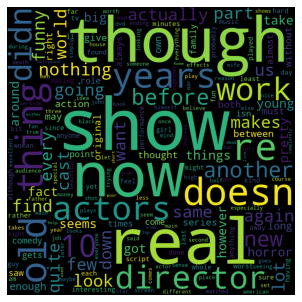

In [50]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=800, max_font_size=200, background_color="black").generate_from_frequencies(text_freq)

  
# plot the WordCloud image                       
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

## Topic Modeling and Document Clustering
One particular technique that is often applied to text data is topic modeling, which is an umbrella term describing the task of assigning each document to one or multiple topics, usually without supervision. A good example for this is news data, which might be categorized into topics like “politics”, “sports”, “finance” and so on. If each document is assigned a single topic, this is the task of clustering the documents. If each document can have more than one topic, the task relates to the decomposition methods. Each of the components we learn then corresponds to one topic, and the coefficients of the components in the representation of a document tell us how strongly related that document is to a particular topic. Often, when people talk about topic modeling, they refer to one particular decomposition method called
Latent Dirichlet Allocation (often LDA for short).

Latent Dirichlet Allocation
Intuitively, the LDA model tries to find groups of words (the topics) that appear together frequently. LDA also requires that each document can be understood as a “mixture” of a subset of the topics. It is important to understand that for the machine learning model a “topic” might not be what we would normally call a topic in everyday speech, but that it resembles more the components extracted by PCA or NMF, which might or might not have a semantic meaning. Even if there is a semantic meaning for an LDA “topic”, it might not be something we’d usually call a topic. Going back to the example of news articles, we might have a collection of articles about sports, politics, and finance, written by two specific authors. In a politics article, we might expect to see words like “governor”, “vote”, “party” etc., while in a sports article we might expect words like “team,” “score,” and “season.” Words in each of these groups will likely appear together, while it’s less likely that, for example, “team” and “governor” will appear together. However, these are not the only groups of words we might expect to appear together. The two reporters might prefer different phrases or different choices of words. Maybe one of them likes to use the word “demarcate” and one likes the word “polarize”. Other “topics” would then be “words often used by reporter A” and “words often used by reporter B”, though these are not topics in the usual sense of the word.

Let’s apply LDA to our movie review dataset to see how it works in practice. For unsupervised text document models, it is often good to remove very common words, as they might otherwise dominate the analysis. We’ll remove words that appear in at least 15 percent of the documents, and we’ll limit the bag-of-words model to the 10,000 words that are most common after removing the top 15 percent:

We will learn a topic model with 10 topics, which is few enough that we can lookat all of them. The topics don’t have an inherent ordering, and changing the number of topics will change all of the topics. We’ll use the *batch* learning method, which is somewhat slower than the default *online* but usually provides better results, and increase *max_iter*.

In [51]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

*LatentDirichletAllocation* has a *components_* attribute that stores how important each word is for each topic. The size of
*components_* is (n_topics, n_words):

In [52]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 10000)


To understand better what the different topics mean, we will look at the most important words for each of the topics.

### Visualizing results with *pyLDAvis* package

*pyLDAvis* package is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

The visualization is intended to be used within an IPython notebook but can also be saved to a stand-alone HTML file for easy sharing.

Interpreting pyLDAvis plots<br>
The LDAvis plot comes in two parts — a 2-dimensional ‘flattened’ replotting of our n-dimensional LDA data and an interactive, varying horizontal bar-chart of term distributions. One important feature to note is that the right-hand bar chart shows the terms in a topic in decreasing order of relevance, but the bars indicate the frequency of the terms. The red section represents the term frequency purely within the particular topic; the red and blue represent the overall term frequency within the corpus of documents.

Adjusting λ (lambda)<br>
If we set λ equal to 1, then our relevance is given purely by the probability of the word to that topic. Setting it to 0 will result in our relevance being dictated by specificity of that word to the topic. Thus, highly frequent words will be downgraded heavily in relevance when we have a lower λ value.


In [53]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, X, vect)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.042002  0.062198       1        1  14.396998
5     -0.112489  0.071210       2        1  13.039474
2     -0.158865 -0.021828       3        1  12.513885
9     -0.001238  0.071196       4        1  12.194265
1     -0.026890  0.126596       5        1  12.027459
4     -0.142538 -0.059503       6        1  12.024693
7      0.167467  0.060445       7        1   7.833401
6     -0.018896 -0.130488       8        1   5.575960
3      0.054957 -0.139099       9        1   5.413955
8      0.196490 -0.040728      10        1   4.979910, topic_info=          Term         Freq        Total Category  logprob  loglift
8074      show  6276.000000  6276.000000  Default  30.0000  30.0000
7924    series  3409.000000  3409.000000  Default  29.0000  29.0000
3133   episode  1656.000000  1656.000000  Default  28.0000  28.0000
3764     funny  4262.000000  4262.000000  Default  27.0000  27.0000
9298        tv  2768.000000  2768.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
8473      star   283.405676  2079.025453  Topic10  -5.9969   1.0070
2649  director   293.363582  4434.519857  Topic10  -5.9624   0.2840
236     actors   286.743022  4469.214811  Topic10  -5.9852   0.2534
4895       job   275.022505  2269.352852  Topic10  -6.0270   0.8894
9956     years   277.261086  4493.221628  Topic10  -6.0189   0.2144

[848 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.067204       10
2         2  0.130713       10
2         3  0.202997       10
2         4  0.032794       10
2         5  0.028406       10
...     ...       ...      ...
9993      4  0.065277   zombie
9994      2  0.027188  zombies
9994      3  0.967124  zombies
9994      7  0.005826  zombies
9999      5  0.984657       zu

[3112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 3, 10, 2, 5, 8, 7, 4, 9])

Judging from the important words, topic 5 seems to be about historical and war movies (war, world, us), topic 3 might be about bad comedies (funny, worst, comedy,...), topic 9 might be about TV series (show, series, episode,...). Topic 6 seems to capture some very common words (didn, saw, am,...), while topic 8 appears to be about children’s movies (kids, action, animation,...) and topic 10 seems to capture award-related reviews (performance, role, ...). Using only 10 topics, each of the topics needs to be very broad, so that they can together cover all the different kinds of reviews in our dataset.

Topic models like LDA are interesting methods to understand large text corpora in the absence of labels or, as here, even if labels are available. The LDA algorithm is randomized, though, and changing the *random_state* parameter canlead to quite different outcomes. While identifying topics can be helpful, any conclusions you draw from an unsupervised model should be taken with a grain of salt, and we recommend verifying your intuition by looking at the documents in a specific topic. The topics produced by the *LDA.transform* method can also sometimes be used as a compact representation for supervised learning. This is particularly helpful when few training examples are available.

In [69]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Naive Bayes Classification
The following exercise is taken from:
https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html

## Gaussian Naive Bayes
Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes. In this classifier, the assumption is that data from each label is drawn from a simple Gaussian distribution. Imagine that you have the following data:

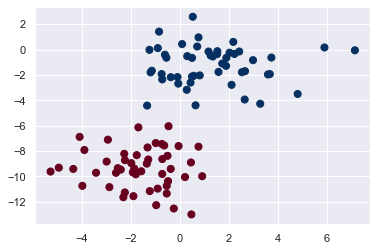

In [70]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions. This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution.

With this generative model in place for each class, we have a simple recipe to compute the likelihood $P(features | L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in *sklearn*'s *naive_bayes.GaussianNB* estimator:

In [71]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Now let's generate some new data and predict the label:

In [72]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is:


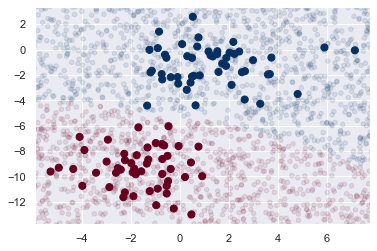

In [73]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

We see a slightly curved boundary in the classifications, in general, the boundary in Gaussian naive Bayes is quadratic.

A nice piece of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute using the *predict_proba* method.
Let's predict the probabilities of belonging to each class. Now, let's see the features (Xnew) of a couple of points, and their probabilities (yprob). 

In [74]:
yprob = model.predict_proba(Xnew)
print(Xnew[-8:])
print(yprob[-8:].round(2))

[[ -5.43515573  -4.80014444]
 [ -5.60098067 -12.92806483]
 [ -0.73121959 -12.88797674]
 [ -0.60342523  -9.64849071]
 [ -3.37121584  -6.71576303]
 [ -4.32134532  -7.70649139]
 [  0.08823081   0.94005305]
 [  7.05928655  -8.44990818]]
[[0.89 0.11]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.   1.  ]
 [0.15 0.85]]


The columns give the posterior probabilities of the first and second label, respectively. If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a useful approach.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results. Still, in many cases—especially as the number of features becomes large—this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method.

Let's now see the distribution of predicted probabilities. 

Text(0.5, 1.0, 'probability of belonging to class 1 -blue')

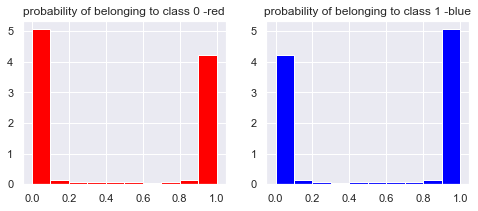

In [76]:
df = pd.DataFrame(yprob, columns = ['prob_0','prob_1'])
fig, ax = plt.subplots(1,2, figsize=(8,3))


ax[0].hist(df['prob_0'], density=True, color='red')
ax[0].set_title('probability of belonging to class 0 -red')
ax[1].hist(df['prob_1'], density=True , color='blue')
ax[1].set_title('probability of belonging to class 1 -blue')

We see that in this case Naive Bayes gives predictions either extremely high or extremely low. Naive Bayes can be used for ranking, but it should not be used directly when actual probability estimates are needed.

## Multinomial Naive Bayes
The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label. Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution. The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribution with a best-fit multinomial distribution.

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified. We will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [77]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [78]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

We can check the target names:

In [79]:
train.target_names

['comp.graphics', 'sci.space', 'soc.religion.christian', 'talk.religion.misc']

Here is a representative entry from the data:

In [80]:
print(train.data[7])

From: bprofane@netcom.com (Gert Niewahr)
Subject: Re: Rumours about 3DO ???
Article-I.D.: netcom.bprofaneC51wHz.HIo
Organization: Netcom Online Communications Services (408-241-9760 login: guest)
Lines: 39

In article <C51Eyz.4Ix@optimla.aimla.com> lex@optimla.aimla.com (Lex van Sonderen) writes:
>In article <h1p4s4g@zola.esd.sgi.com> erik@westworld.esd.sgi.com (Erik Fortune) writes:
>>> better than CDI
>>*Much* better than CDI.
>Of course, I do not agree.  It does have more horsepower.  Horsepower is not
>the only measurement for 'better'.  It does not have full motion, full screen
>video yet.  Does it have CD-ROM XA?
>
>>> starting in the 4 quarter of 1993
>>The first 3DO "multiplayer" will be manufactured by panasonic and will be 
>>available late this year.   A number of other manufacturers are reported to 
>>have 3DO compatible boxes in the works.
>Which other manufacturers?
>We shall see about the date.

A 3DO marketing rep. recently offered a Phillips marketing rep. a $100
bet t

In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers. For this we will use the TF-IDF vectorizer, and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [82]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator. For example, here is the confusion matrix between the true and predicted labels for the test data:

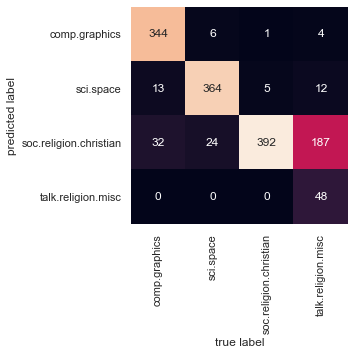

In [83]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity. This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for any string, using the *predict* method of this pipeline. Here's a quick utility function that will return the prediction for a single string:

In [84]:
train.target_names[model.predict(['determining the screen resolution'])[0]]

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking. Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model. That said, they have several advantages:

They are extremely fast for both training and prediction
They provide straightforward probabilistic prediction
They are often very easily interpretable
They have very few (if any) tunable parameters
These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification. If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem. If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:

When the naive assumptions actually match the data (very rare in practice)
For very well-separated categories, when model complexity is less important
For very high-dimensional data, when model complexity is less important
The last two points seem distinct, but they actually are related: as the dimension of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in every single dimension to be close overall). This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information. For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.

Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model. That said, they have several advantages:

- They are extremely fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often very easily interpretable
- They have very few (if any) tunable parameters
These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification. If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem. If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:

- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important
The last two points seem distinct, but they actually are related: as the dimension of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in every single dimension to be close overall). This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information. For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.